In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from xgboost import XGBRegressor
import shap

In [4]:
def cleanUp(df):
    df['annual_gdp']=df[' gdp_for_year ($) '].str.replace(',','')
    
    df=df.drop([' gdp_for_year ($) ','country-year', 'suicides/100k pop'], axis=1)
    df['annual_gdp']=df['annual_gdp'].astype(int)
    
    countrySer=df.groupby('country')["HDI for year"].mean()
    def HDIcleanup(data):
        country=data[0]
        HDI=data[1]
        if np.isnan(HDI):       
            return countrySer[country]
        else:
            return HDI
    df['HDI_for_year']=df[['country','HDI for year']].apply(HDIcleanup,axis=1)
    df=df.drop('HDI for year', axis=1)
    df=df.dropna()
    y=df[['year','suicides_no']]
    df=df.drop('suicides_no',axis=1)
    return df, y

In [5]:
df= pd.read_csv('master.csv')

In [6]:
df, y = cleanUp(df)

In [7]:
df.describe()

,year,population,gdp_per_capita ($),annual_gdp,HDI_for_year
count,26334.000000,2.633400e+04,26334.000000,2.633400e+04,26334.000000
mean,2001.306448,1.753087e+06,17017.479836,4.494139e+11,0.774271
std,8.480270,3.804919e+06,19215.718811,1.488713e+12,0.087415
min,1985.000000,4.240000e+02,251.000000,1.456417e+08,0.483000
25%,1995.000000,9.930000e+04,3424.000000,9.024567e+09,0.707900
50%,2002.000000,4.325410e+05,9070.000000,4.641892e+10,0.779600
75%,2009.000000,1.414290e+06,25165.000000,2.506385e+11,0.853000
max,2016.000000,4.380521e+07,126352.000000,1.812071e+13,0.944000


This code splits them up by the year and I think I like the split

In [11]:
X_train=df[df['year']<2005]
X_val=df[(df['year']>=2005) & (df['year']<2010)]
X_test=df[df['year']>=2010]
y_train=y[y['year']<2005]['suicides_no']
y_val=y[(y['year']>=2005) & (y['year']<2010)]['suicides_no']
y_test=y[y['year']>=2010]['suicides_no']
X_train.shape, X_val.shape, X_test.shape,y_train.shape,y_val.shape,y_test.shape

((15840, 9), (4896, 9), (5598, 9), (15840,), (4896,), (5598,))

In [12]:
#begin with mean baseline
y_train.mean()
y_pred=np.full_like(y_train, y_train.mean())
mean_absolute_error(y_train, y_pred)

273.5008207070707

In [21]:
encoder=ce.OrdinalEncoder()
model=XGBRegressor(n_estimators=5000, learning_rate=.5, n_jobs=-1)

In [22]:
X_train_enc=encoder.fit_transform(X_train)
X_val_enc=encoder.transform(X_val)
X_test_enc=encoder.transform(X_test)

evals=[(X_train_enc,y_train),(X_val_enc, y_val)]

model.fit(X_train_enc, y_train, eval_set=evals, early_stopping_rounds=50, eval_metric='mae')

[0]	validation_0-mae:150.987	validation_1-mae:137.511
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:128.42	validation_1-mae:128.765
[2]	validation_0-mae:124.728	validation_1-mae:129.976
[3]	validation_0-mae:123.052	validation_1-mae:131.439
[4]	validation_0-mae:115.929	validation_1-mae:127.901
[5]	validation_0-mae:113.329	validation_1-mae:126.193
[6]	validation_0-mae:108.588	validation_1-mae:129.404
[7]	validation_0-mae:106.179	validation_1-mae:127.882
[8]	validation_0-mae:104.367	validation_1-mae:124.366
[9]	validation_0-mae:99.3381	validation_1-mae:117.711
[10]	validation_0-mae:95.988	validation_1-mae:113.701
[11]	validation_0-mae:94.5393	validation_1-mae:114.163
[12]	validation_0-mae:93.7501	validation_1-mae:112.711
[13]	validation_0-mae:91.8293	validation_1-mae:111.89
[14]	validation_0-mae:89.2385	validation_1-mae:110.734
[15]	validation_0-mae:86.0242	v

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=5000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

In [15]:
row=X_train.iloc[[6184]]
row

,country,year,sex,age,population,gdp_per_capita ($),generation,annual_gdp,HDI_for_year
10206,Greece,2000,male,15-24 years,823264,12509,Generation X,130133845771,0.799


In [27]:
model.predict(X_train_enc).min()

-401.3993

In [16]:
explainer=shap.TreeExplainer(model)
row_enc=encoder.transform(row)
shap_values= explainer.shap_values(row_enc)
model.predict(row_enc)

array([32.686573], dtype=float32)

In [17]:
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values, 
    features=row
)

In [28]:
model=RandomForestRegressor(n_estimators=100, n_jobs=-1)
model.fit(X_train_enc, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [19]:
-cross_val_score(model,X_val_enc,y_val, cv=5, scoring='neg_mean_absolute_error').mean()

158.93672650976632

In [29]:
model.predict(X_train_enc).min()

0.0

In [30]:
explainer=shap.TreeExplainer(model)
row_enc=encoder.transform(row)
shap_values= explainer.shap_values(row_enc)
model.predict(row_enc)

array([30.72])

In [31]:
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values, 
    features=row
)

In [17]:
y_pred=model.predict(X_train_enc)

In [18]:
y_pred.min()

0.0

The random forest regressor is giving more accurate results because it doesn't predict values less than 0. I'm not sure why this is.

In [42]:
def shapPlot(row_num, model, df):
    explainer=shap.TreeExplainer(model)
    row=df.loc[[row_num]]
    row_enc=encoder.transform(row)
    shap_values= explainer.shap_values(row_enc)
    
    shap.initjs()
    
    return shap.force_plot(
        base_value=explainer.expected_value,
        shap_values=shap_values,
        features=row
    )

In [43]:
shapPlot(24188, model, X_train)

In [23]:
row_enc=encoder.transform(df.loc[[6184]])

In [24]:
model.predict(row_enc)

array([1.59])

In [44]:
import eli5
from eli5.sklearn import PermutationImportance

In [46]:
permuter= PermutationImportance(
    model,
    scoring='neg_mean_absolute_error',
    n_iter=5
)

permuter.fit(X_train_enc, y_train)

PermutationImportance(cv='prefit',
                      estimator=RandomForestRegressor(bootstrap=True,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators=100,
                                                      n_jobs=-1,
                                                      oob_score=False,
   

In [48]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_train.columns.tolist()
)

Weight,Feature
237.3735 ± 4.7427,population
121.5449 ± 3.5957,annual_gdp
103.4741 ± 5.4666,sex
97.6514 ± 2.8166,age
39.6757 ± 1.6169,country
34.0532 ± 1.4450,HDI_for_year
19.8167 ± 0.9126,generation
17.2977 ± 0.4321,gdp_per_capita ($)


In [52]:
def pdpSingle(feature, model, df):
    df_enc=encoder.transform(df)
    isolated= pdp_isolate(
        model=model,
        dataset=df_enc,
        model_features=df.columns.tolist(),
        feature=feature,
        num_grid_points=100
    )
    
    return pdp_plot(isolated, feature, plot_lines=True, frac_to_plot=30)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c30402320>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c304091d0>})

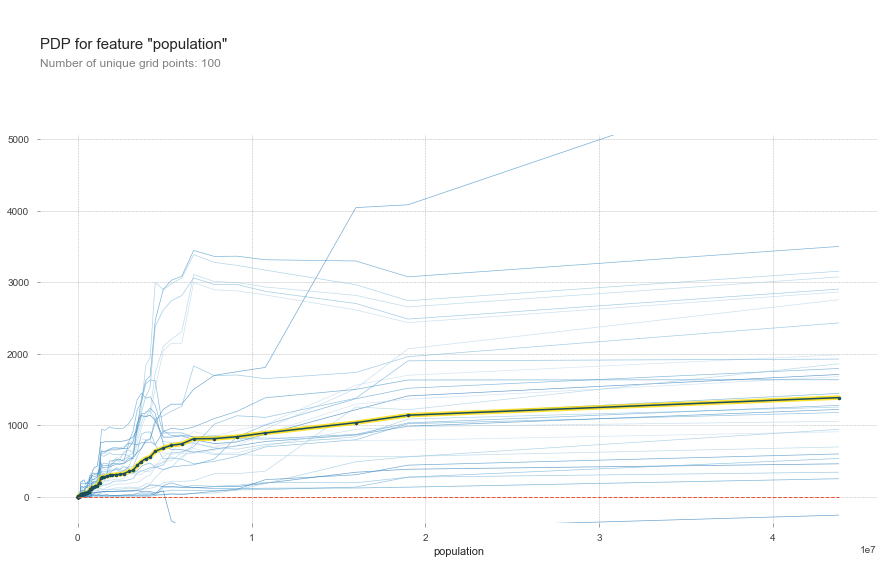

In [53]:
pdpSingle('population', model, X_train)

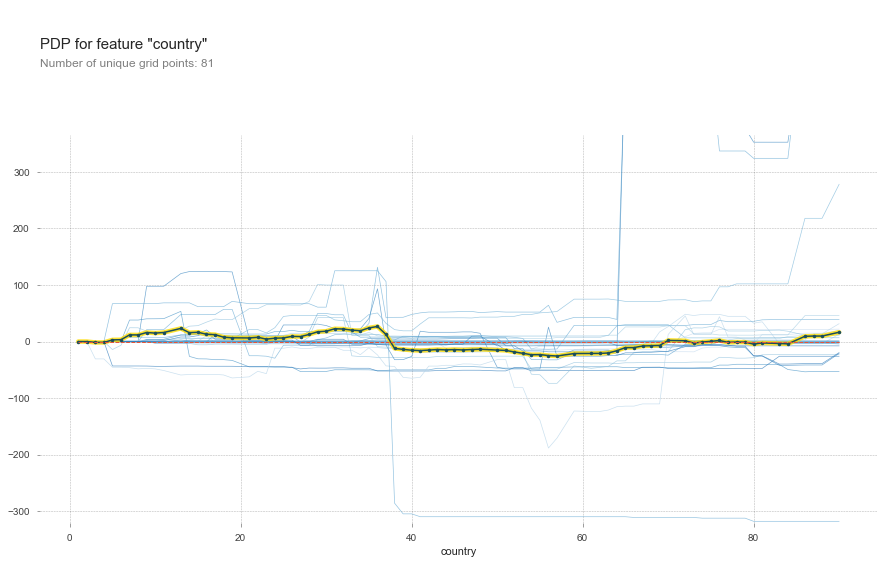

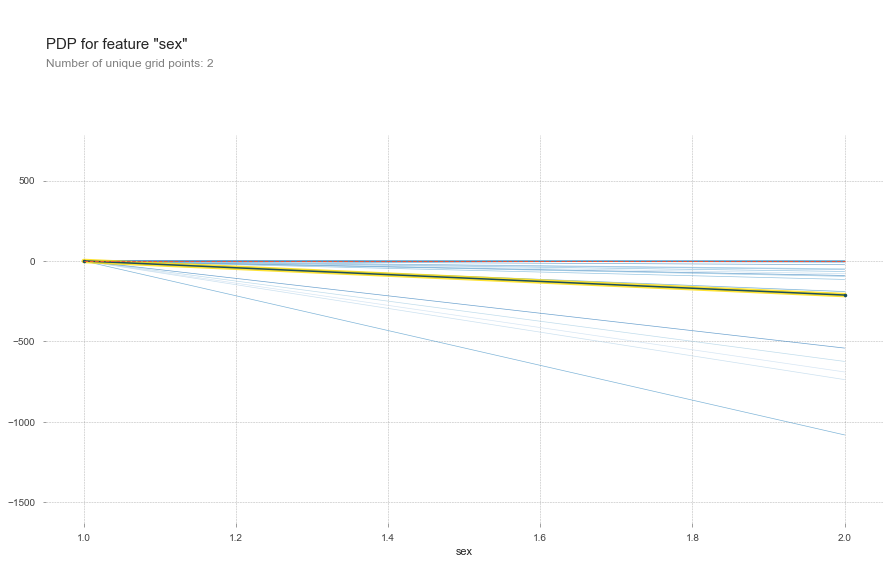

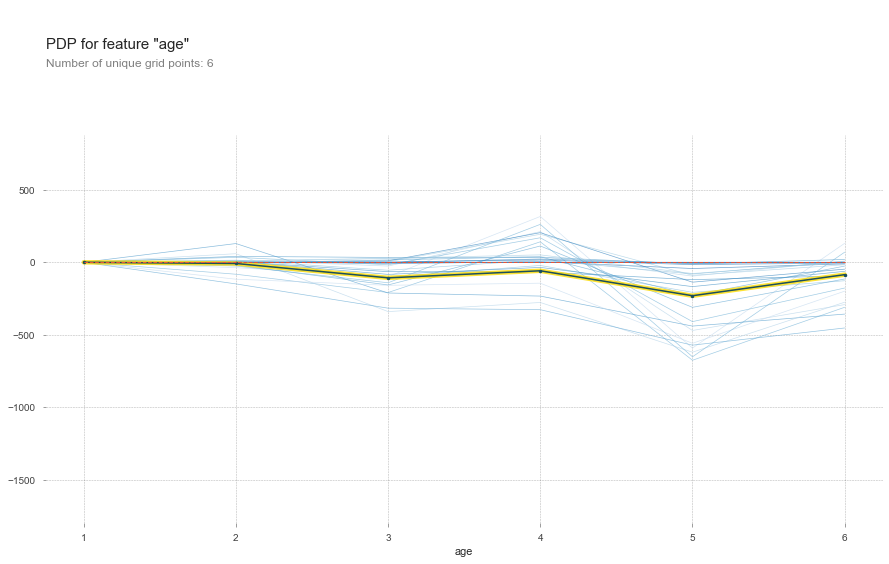

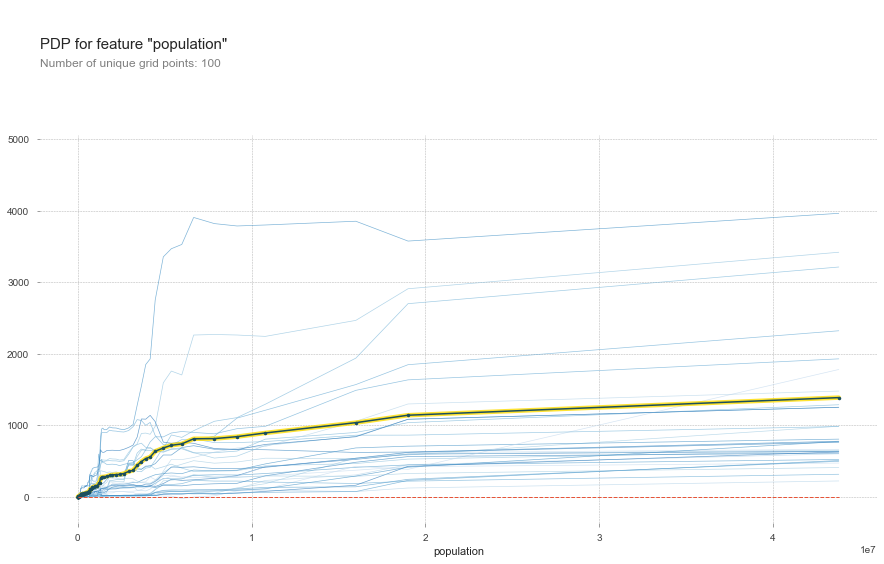

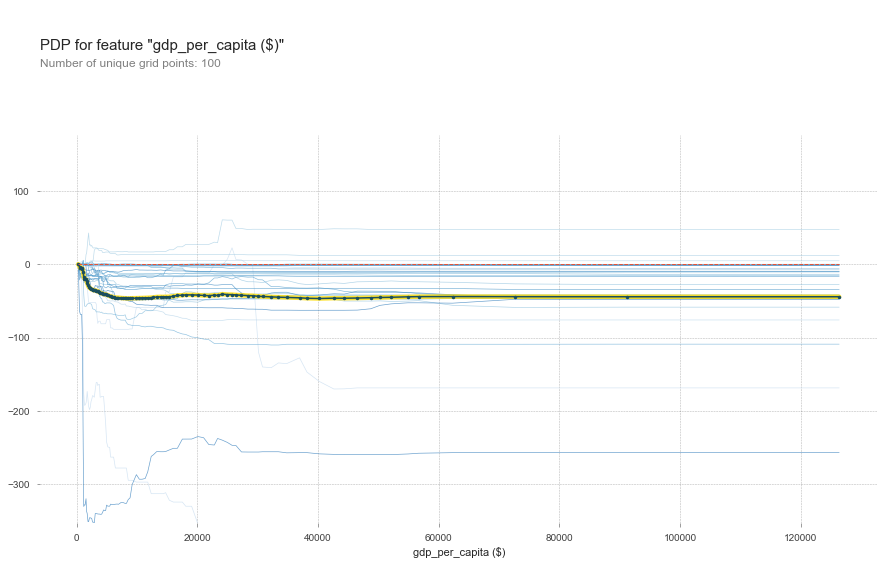

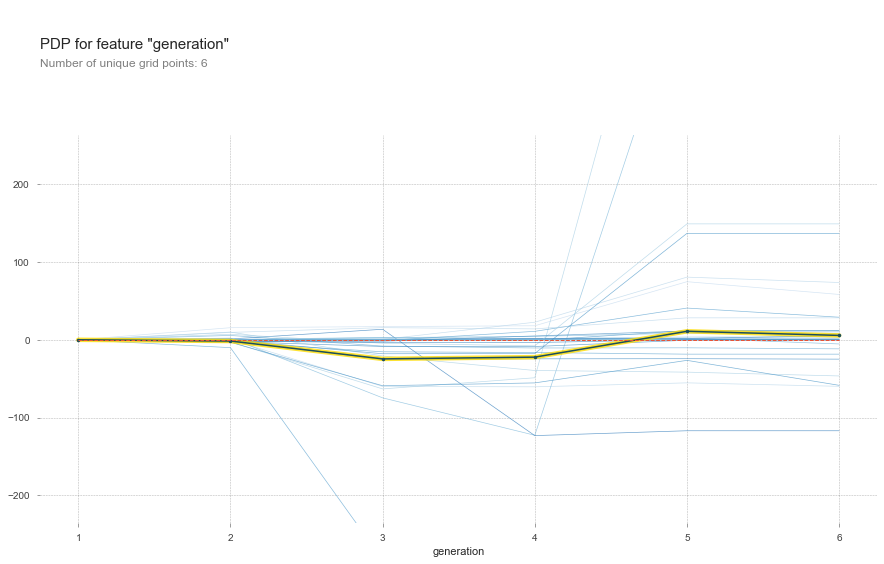

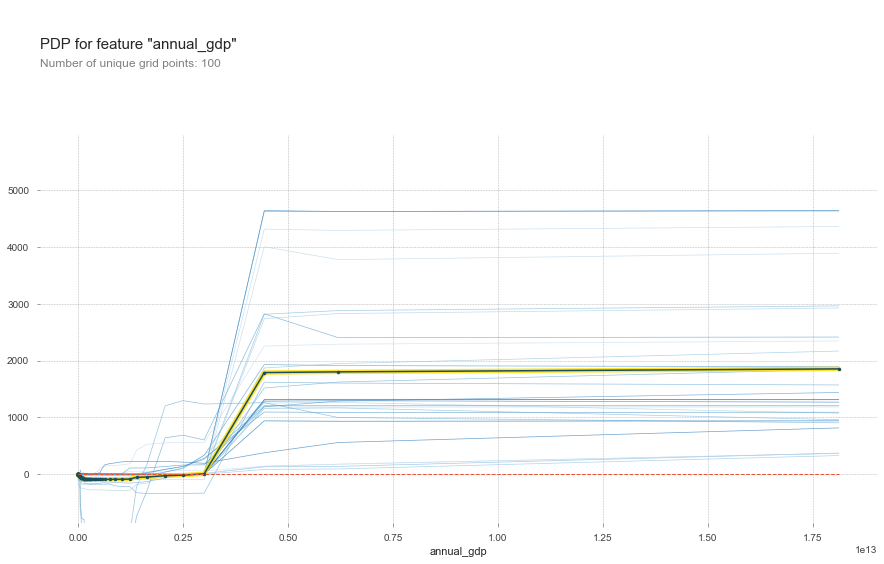

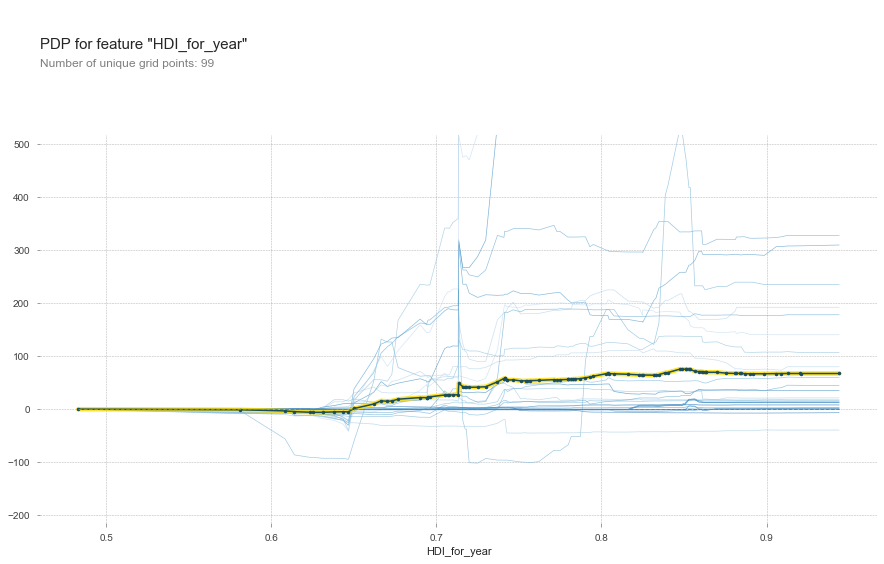

In [54]:
for col in X_train.columns.tolist():
    pdpSingle(col, model, X_train)

In [55]:
y_pred=model.predict(X_train_enc)

In [57]:
(y_pred==0).sum()

398

In [66]:
X_train_enc['prediction']=y_pred
X_train_enc['actual']=y_train

In [76]:
X_train_enc[X_train_enc['actual']-X_train_enc['prediction']>0].shape, X_train_enc[X_train_enc['actual']-X_train_enc['prediction']<0].shape

((5801, 10), (8588, 10))

The model tends to predict values that are lower than the actual values

In [62]:
shapPlot(10471, model, X_train)

In [73]:
shapPlot(19273, model, X_train)